# bias studies with full systematics

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 47169,
  "iopub_port": 51513,
  "stdin_port": 42617,
  "control_port": 55895,
  "hb_port": 47297,
  "ip": "127.0.0.1",
  "key": "cd538a38-50f5d6c7fae30b40152fa7ab",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-f68371f0-c567-45ec-8e39-f30f63edebf1.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/test_new/'
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee', 'emu', 'mumu',  
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
plot_labels = fh.fancy_labels

# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes, process_cut=0.1)

In [6]:
# make some control plots 
params = fit_data._parameters
params_pre = fit_data.get_params_init().values

# test systematic uncertainties
ntoys = 1000
pval, perr = params['val_init'].values, params['err_init'].values
perr[:4] = [0.001, 0.001, 0.001, 0.007]
prand = pval[:7] + np.random.randn(pval.size, ntoys).T*perr 
prand = np.concatenate([np.outer(np.ones(ntoys), fit_data._beta_init), prand], axis=1)
toy_data = [{category: fit_data.mixture_model(p, category) for category in fit_data._model_data.keys()} for p in prand] 

br_tau = [0.1783, 0.1741, 0.6476]
beta_scan_vals = ScanParameters(['beta_e', 'beta_mu', 'beta_tau'], 
                                [(0.104, 0.112), (0.104, 0.112), (0.104, 0.112)], 
                                [20, 20, 20]
                                )
sv = np.array(beta_scan_vals.get_scan_vals()[0])
beta_h = np.transpose([1 - np.sum(sv, axis=1)])
sv = np.hstack((sv, beta_h))


def simplified_objective(p, data, plen):
    p = np.concatenate([p[:plen], params_pre[plen:]])
    return fit_data.objective(p, data, subtract_cost_init=True)

# calculate covari ance matrix from the inverse of the Hessian of the NLL
results = []
for sample in tqdm_notebook(toy_data[:10]):
    result = minimize(simplified_objective, params_pre[:7], 
                      method = 'TNC', 
                      options = dict(maxiter = 5000),
                      args = (sample, 7)
                     )
    results.append(result.x)
    print(result)
    #dchi2.append(fit_data.objective(p_init, sample) - result.fun)
    #fobj = partial(fit_data.objective, data=sample, cost_type='poisson')
    #cov.append(fh.calculate_covariance(fobj, result.x))
    
results = np.array(results)
#results = prand

     fun: 4131864.465639755
     jac: array([19062.683,  7496.029,  2352.148, 17008.93 ,  -583.008,  4426.762,
        -755.489])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 610
     nit: 98
  status: 2
 success: True
       x: array([0.095, 0.092, 0.126, 0.687, 0.177, 0.173, 0.634])
     fun: 4644501.668120172
     jac: array([ -4264.712,  28592.348, -14345.348,  12364.611,   2595.782,
         1448.02 ,   -213.459])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 577
     nit: 76
  status: 2
 success: True
       x: array([0.089, 0.091, 0.122, 0.698, 0.178, 0.173, 0.64 ])
     fun: 471534.59458579496
     jac: array([13102.591, -3187.358, 31820.685,    83.074,  -425.056,  -640.75 ,
         255.927])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 142
     nit: 28
  status: 2
 success: True
       x: array([0.107, 0.11 , 0.105, 0.678, 0.178, 0.175, 0.642])
     fun: -999098.0817910619
     jac: array([-22438.914,  -1358.986,  21440.908,  34283.474, -10395.05 ,
    

ValueError: operands could not be broadcast together with shapes (10,3) (81,) 

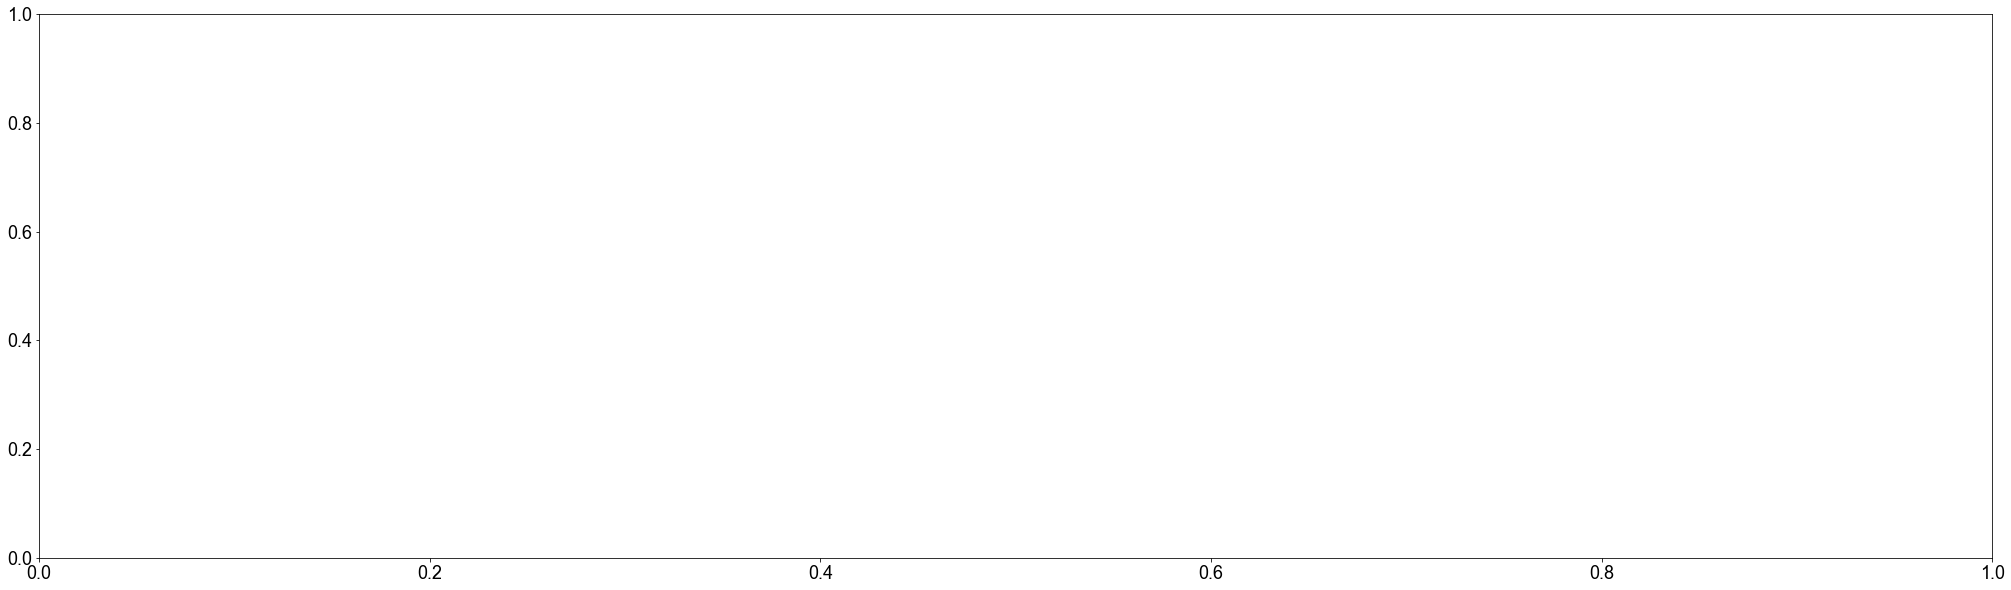

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10), facecolor='white')

#ax.boxplot((prand[:,4:] - pval)/perr)
#ax.boxplot((results[:,4:] - pval)/perr)
diff_pre = (prand[:,4:] - pval)/perr
diff_post = (results[:,4:] - pval)/perr
xticks = np.arange(1, 82)
ax.errorbar(xticks, diff_pre.mean(axis=0), diff_pre.std(axis=0), fmt='C0o', capsize=4)
ax.errorbar(xticks,  diff_post.mean(axis=0), diff_post.std(axis=0), fmt='C1o', capsize=4)
ax.fill_between([-0.5, 82.5], [-1, -1], [1, 1], color='C0', alpha=0.2)
ax.set_xticks(xticks)
ax.set_xticklabels(params.label[4:])
ax.set_xlim(0.5, 81.5)
ax.grid(linestyle='--', axis='y')

plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

plt.show()